In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from scipy.stats import multivariate_normal


# you can choose one of the following package for image reading/processing

import cv2
import PIL


**1. Support Vector Machine**

In [2]:
data = pd.read_csv("./x_train.csv",header= None)/255
label = pd.read_csv("./t_train.csv",header= None)

## 1. It is popular to use principal component analysis (PCA) to reduce the dimension of images to d = 2. Please implement it by yourself instead of using the method from sklearn.

In [3]:
data_mean = data - np.mean(data,axis = 0)
K = np.cov(data_mean.T)
eig_vals, eig_vecs = np.linalg.eig(K)
eig_sort = np.argsort(eig_vals)
reverse = np.flipud(eig_sort)
eig_vecs = eig_vecs.T[reverse]
PCA_data = np.real(np.dot(data_mean,eig_vecs[0:2].T))
print(PCA_data.shape)

(300, 2)


## 2. Describe the difference between two decision approaches (one-versus-the-rest and one-versus-one). Decide which one you want to choose and explain why you choose this approach. 

Both the two methods are use for multi-class classification(Classification tasks with more than two classes)，the difference is that One-versus-the-rest splits a multi-class classification into one binary classification problem per class，相當於K個類別會有K個分類器 ;And One-versus-one splits a multi-class classification into one binary classification problem per each pair of classes，相當於K個類別需要K(K-1)/2個分類器.

For this homework I choose to use one-versus-one，the reason is the homework only has three categories，so both methods don't make much difference，and also one-versus-one is more easy and intuitive，且只需要看此樣本被判斷哪一類的次數最多，這個樣本就判給哪一類。

## 3. Use the principle values projected to top two eigenvectors obtained from PCA, and build a SVM with linear kernel to do multi-class classification. You can decide the upper bound C of an by yourself or just use the default value provided by sklearn. Then, plot the corresponding decision boundary and show the support vectors. The sample figures are provided below.

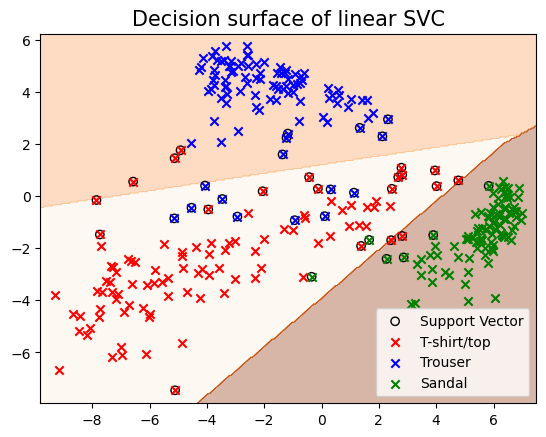

In [4]:
C = 0.45
def lin_kernel(x_i, x_j):
    return np.dot(x_i, x_j.T)

label = np.array(label)
label = label.ravel()
clf = svm.SVC(kernel='linear', C=C, decision_function_shape='ovo')
clf.fit(PCA_data, label)
coe = clf.dual_coef_
indice = clf.support_ 

target1 = np.zeros(1)-1
target2 = np.zeros(1)
target3 = np.ones(1)

alpha = np.zeros((300, 2))
alpha[indice] = np.abs(coe.T)
# print(alpha.shape)
alpha1 = np.array(alpha[0,0]).reshape(1,)
alpha2 = np.zeros(1)
alpha3 = np.array(alpha[0,1]).reshape(1,)

for i in range(299):
    if label[i+1] == 0:
        target1 = np.concatenate((target1,np.ones(1)))
        target2 = np.concatenate((target2,np.ones(1)))
        target3 = np.concatenate((target3,np.zeros(1)-1))
        alpha1 = np.concatenate((alpha1,np.array(alpha[i+1,0]).reshape(1,)))
        alpha2 = np.concatenate((alpha2,np.array(alpha[i+1,1]).reshape(1,)))
        alpha3 = np.concatenate((alpha3,np.zeros(1)))
    elif label[i+1] == 1:
        target1 = np.concatenate((target1,np.zeros(1)-1))
        target2 = np.concatenate((target2,np.zeros(1)))
        target3 = np.concatenate((target3,np.ones(1)))
        alpha1 = np.concatenate((alpha1,np.array(alpha[i+1,0]).reshape(1,)))
        alpha2 = np.concatenate((alpha2,np.zeros(1)))
        alpha3 = np.concatenate((alpha3,np.array(alpha[i+1,1]).reshape(1,)))
    else:
        target1 = np.concatenate((target1,np.zeros(1)))
        target2 = np.concatenate((target2,np.zeros(1)-1))
        target3 = np.concatenate((target3,np.zeros(1)-1))
        alpha1 = np.concatenate((alpha1,np.zeros(1)))
        alpha2 = np.concatenate((alpha2,np.array(alpha[i+1,0]).reshape(1,)))
        alpha3 = np.concatenate((alpha3,np.array(alpha[i+1,1]).reshape(1,)))

w1 = np.dot((alpha1*target1),PCA_data)
w2 = np.dot((alpha2*target2),PCA_data)
w3 = np.dot((alpha3*target3),PCA_data)

m1 = np.where(((alpha1 > 0) & (alpha1 < C)))[0]
m2 = np.where(((alpha2 > 0) & (alpha2 < C)))[0]
m3 = np.where(((alpha3 > 0) & (alpha3 < C)))[0]

s1 = np.where(alpha1 > 0)[0]
s2 = np.where(alpha2 > 0)[0]
s3 = np.where(alpha3 > 0)[0]

b1 = 0
b2 = 0
b3 = 0
if len(m1) != 0:
    b1 = np.mean(target1[m1]-np.dot((alpha1*target1)[s1], lin_kernel(PCA_data[m1], PCA_data[s1]).T))
if len(m2) != 0:
    b2 = np.mean(target2[m2]-np.dot((alpha2*target2)[s2], lin_kernel(PCA_data[m2], PCA_data[s2]).T))
if len(m1) != 0:
    b3 = np.mean(target3[m3]-np.dot((alpha3*target3)[s3], lin_kernel(PCA_data[m3], PCA_data[s3]).T))
# print(b1)
b_d = {0:b1,1:b2,2:b3}
w_d = {0:w1,1:w2,2:w3}
class_d = {0:[0,1],1:[0,2],2:[1,2]}

def predict(x,b_d,w_d,class_d):
    tmp = []
    for i in range(len(x)):
        maximum = []
        for j in range(3):
            y = np.dot(w_d[j],x[i].T)+b_d[j]
            if y <= 0: 
                maximum.append(class_d[j][1])
            else:
                maximum.append(class_d[j][0])
        tmp.append(max(set(maximum), key = maximum.count)) 
    return tmp

def plot(xx,yy,b_d,w_d,class_d):
    pre = np.zeros((len(xx),len(xx[0])))
    for i in range(len(xx)):
        pre[i,:] = np.array(predict(np.column_stack((xx[0],yy[i])),b_d,w_d,class_d))
    return pre

xx, yy = np.meshgrid(np.arange(min(PCA_data[:, 0])-0.5, max(PCA_data[:, 0])+0.5, 0.05),np.arange(min(PCA_data[:, 1])-0.5, max(PCA_data[:, 1])+0.5, 0.05))    
pre = plot(xx,yy,b_d,w_d,class_d)
c0 = np.where(label == 0)[0]
c1 = np.where(label == 1)[0]
c2 = np.where(label == 2)[0]
plt.title("Decision surface of linear SVC", fontsize = 15)
plt.contourf(xx, yy, pre, alpha=0.35, cmap=plt.cm.Oranges)
plt.scatter(PCA_data[clf.support_, 0], PCA_data[clf.support_, 1],color = 'black',facecolors='none', marker = "o",label = "Support Vector")
plt.scatter(PCA_data[c0][:, 0], PCA_data[c0][:, 1], color = 'red', marker = 'x', label = "T-shirt/top")
plt.scatter(PCA_data[c1][:, 0], PCA_data[c1][:, 1], color = 'blue', marker = 'x', label = "Trouser")
plt.scatter(PCA_data[c2][:, 0], PCA_data[c2][:, 1], color = 'green', marker = 'x', label = "Sandal")
plt.legend()
plt.show()

## Bonus:Repeat 3 with polynomial kernel (degree = 2).

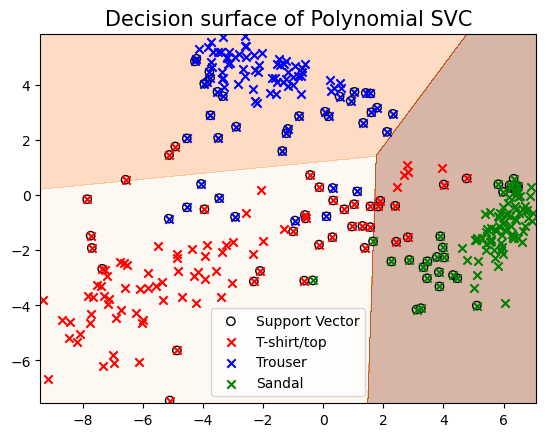

In [5]:
poly_C = 10

def poly_kernel(x_i, x_j):
    if x_i.ndim == 1:
        x_i = x_i.reshape(1,2)
    if x_j.ndim == 1:
        x_j = x_j.reshape(1,2)
    phi_x_i = np.vstack((x_i[:,0]**2, np.sqrt(2)*x_i[:,0]*x_i[:,1], x_i[:,1]**2)).T
    phi_x_j = np.vstack((x_j[:,0]**2, np.sqrt(2)*x_j[:,0]*x_j[:,1], x_j[:,1]**2)).T
    return np.dot(phi_x_i, phi_x_j.T)

poly_clf = svm.SVC(kernel='poly', C = poly_C, degree=2, decision_function_shape='ovo')
poly_clf.fit(PCA_data, label)
coe_poly = poly_clf.dual_coef_
indice_poly = poly_clf.support_ 

poly_target1 = np.zeros(1)-1
poly_target2 = np.zeros(1)
poly_target3 = np.ones(1)

poly_alpha = np.zeros((300, 2))
poly_alpha[indice_poly] = np.abs(coe_poly.T)
# print(poly_alpha.shape)
poly_alpha1 = np.array(poly_alpha[0,0]).reshape(1,)
poly_alpha2 = np.zeros(1)
poly_alpha3 = np.array(poly_alpha[0,1]).reshape(1,)

for i in range(299):
    if label[i+1] == 0:
        poly_target1 = np.concatenate((poly_target1,np.ones(1)))
        poly_target2 = np.concatenate((poly_target2,np.ones(1)))
        poly_target3 = np.concatenate((poly_target3,np.zeros(1)-1))
        poly_alpha1 = np.concatenate((poly_alpha1,np.array(poly_alpha[i+1,0]).reshape(1,)))
        poly_alpha2 = np.concatenate((poly_alpha2,np.array(poly_alpha[i+1,1]).reshape(1,)))
        poly_alpha3 = np.concatenate((poly_alpha3,np.zeros(1)))
    elif label[i+1] == 1:
        poly_target1 = np.concatenate((poly_target1,np.zeros(1)-1))
        poly_target2 = np.concatenate((poly_target2,np.zeros(1)))
        poly_target3 = np.concatenate((poly_target3,np.ones(1)))
        poly_alpha1 = np.concatenate((poly_alpha1,np.array(poly_alpha[i+1,0]).reshape(1,)))
        poly_alpha2 = np.concatenate((poly_alpha2,np.zeros(1)))
        poly_alpha3 = np.concatenate((poly_alpha3,np.array(poly_alpha[i+1,1]).reshape(1,)))
    else:
        poly_target1 = np.concatenate((poly_target1,np.zeros(1)))
        poly_target2 = np.concatenate((poly_target2,np.zeros(1)-1))
        poly_target3 = np.concatenate((poly_target3,np.zeros(1)-1))
        poly_alpha1 = np.concatenate((poly_alpha1,np.zeros(1)))
        poly_alpha2 = np.concatenate((poly_alpha2,np.array(poly_alpha[i+1,0]).reshape(1,)))
        poly_alpha3 = np.concatenate((poly_alpha3,np.array(poly_alpha[i+1,1]).reshape(1,)))

poly_w1 = np.dot((poly_alpha1*poly_target1),PCA_data)
poly_w2 = np.dot((poly_alpha2*poly_target2),PCA_data)
poly_w3 = np.dot((poly_alpha3*poly_target3),PCA_data)

poly_m1 = np.where(((poly_alpha1 > 0) & (poly_alpha1 < poly_C)))[0]
poly_m2 = np.where(((poly_alpha2 > 0) & (poly_alpha2 < poly_C)))[0]
poly_m3 = np.where(((poly_alpha3 > 0) & (poly_alpha3 < poly_C)))[0]

poly_s1 = np.where(poly_alpha1 > 0)[0]
poly_s2 = np.where(poly_alpha2 > 0)[0]
poly_s3 = np.where(poly_alpha3 > 0)[0]

poly_b1 = 0
poly_b2 = 0
poly_b3 = 0
if len(poly_m1) != 0:
    poly_b1 = np.mean(poly_target1[poly_m1]-np.dot((poly_alpha1*poly_target1)[poly_s1], poly_kernel(PCA_data[poly_m1], PCA_data[poly_s1]).T))
if len(poly_m2) != 0:
    poly_b2 = np.mean(poly_target2[poly_m2]-np.dot((poly_alpha2*poly_target2)[poly_s2], poly_kernel(PCA_data[poly_m2], PCA_data[poly_s2]).T))
if len(poly_m1) != 0:
    poly_b3 = np.mean(poly_target3[poly_m3]-np.dot((poly_alpha3*poly_target3)[poly_s3], poly_kernel(PCA_data[poly_m3], PCA_data[poly_s3]).T))
# print(poly_b1)
poly_b_d = {0:poly_b1,1:poly_b2,2:poly_b3}
poly_w_d = {0:poly_w1,1:poly_w2,2:poly_w3}
poly_class_d = {0:[0,1],1:[0,2],2:[1,2]}

poly_xx, poly_yy = np.meshgrid(np.arange(min(PCA_data[:, 0])-0.1, max(PCA_data[:, 0])+0.1, 0.01),np.arange(min(PCA_data[:, 1])-0.1, max(PCA_data[:, 1])+0.1, 0.01))    
poly_pre = plot(poly_xx,poly_yy,poly_b_d,poly_w_d,poly_class_d)
poly_c0 = np.where(label == 0)[0]
poly_c1 = np.where(label == 1)[0]
poly_c2 = np.where(label == 2)[0]
plt.title("Decision surface of Polynomial SVC", fontsize = 15)
plt.contourf(poly_xx, poly_yy, poly_pre, alpha=0.35, cmap=plt.cm.Oranges)
plt.scatter(PCA_data[poly_clf.support_, 0], PCA_data[poly_clf.support_, 1],color = 'black',facecolors='none', marker = "o",label = "Support Vector")
plt.scatter(PCA_data[poly_c0][:, 0], PCA_data[poly_c0][:, 1], color = 'red', marker = 'x', label = "T-shirt/top")
plt.scatter(PCA_data[poly_c1][:, 0], PCA_data[poly_c1][:, 1], color = 'blue', marker = 'x', label = "Trouser")
plt.scatter(PCA_data[poly_c2][:, 0], PCA_data[poly_c2][:, 1], color = 'green', marker = 'x', label = "Sandal")
plt.legend()
plt.show()

## 2. Gaussian Mixture Model**

K = 2:
------------------------------
K-means:   R   |  G   |  B
------------------------------
0      :  120  | 139  | 182
------------------------------
1      :   14  |  61  |  22
------------------------------


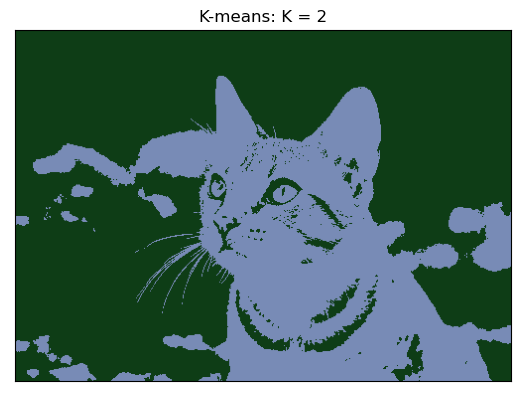



GMM K = 2:
------------------------------
           R   |  G   |  B
------------------------------
0      :  136  | 152  | 173
------------------------------
1      :   40  |  72  |  34
------------------------------


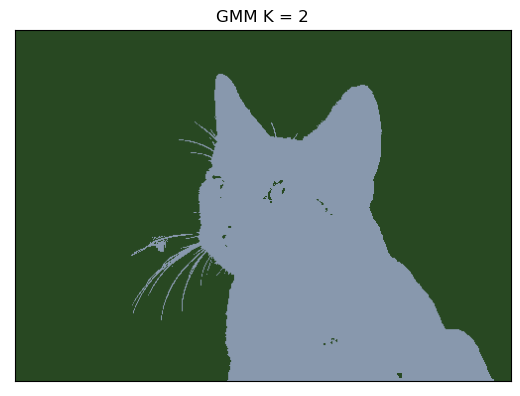

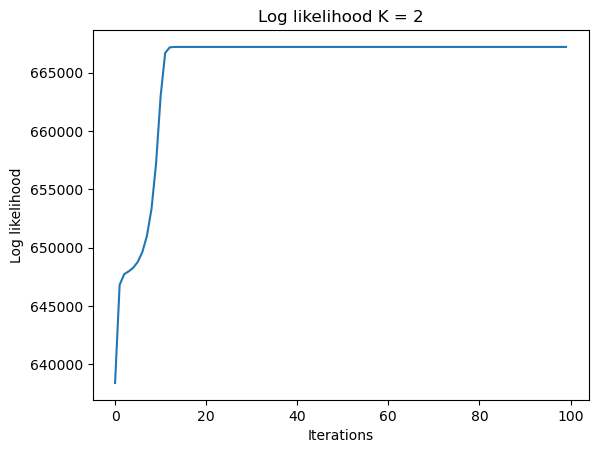



K = 3:
------------------------------
K-means:   R   |  G   |  B
------------------------------
0      :   86  | 117  |  62
------------------------------
1      :   77  |  86  |  83
------------------------------
2      :   13  |  42  |  16
------------------------------


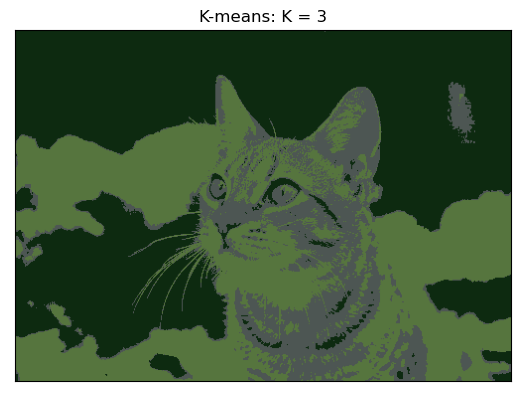



GMM K = 3:
------------------------------
           R   |  G   |  B
------------------------------
0      :   66  |  95  |  48
------------------------------
1      :  135  | 151  | 172
------------------------------
2      :   16  |  52  |  22
------------------------------


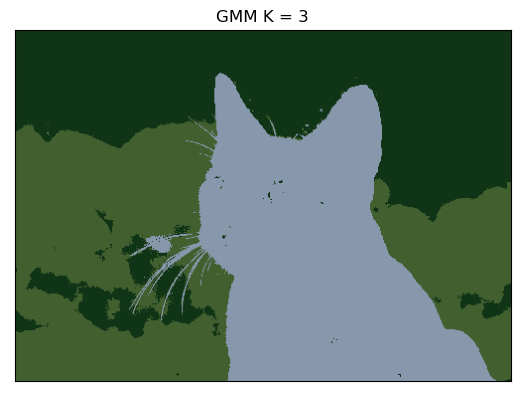

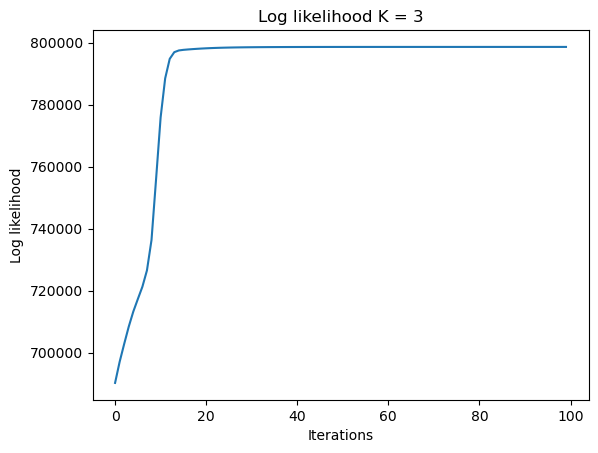



K = 7:
------------------------------
K-means:   R   |  G   |  B
------------------------------
0      :  133  | 145  | 151
------------------------------
1      :  148  | 146  | 146
------------------------------
2      :   85  | 119  |  58
------------------------------
3      :   14  |  40  |  16
------------------------------
4      :  130  | 149  | 154
------------------------------
5      :  132  | 157  | 189
------------------------------
6      :   22  |  77  |  32
------------------------------


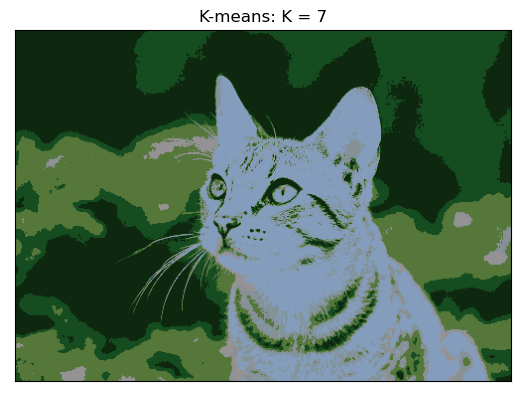



GMM K = 7:
------------------------------
           R   |  G   |  B
------------------------------
0      :   89  | 102  | 113
------------------------------
1      :  165  | 176  | 165
------------------------------
2      :   76  | 108  |  55
------------------------------
3      :   16  |  40  |  18
------------------------------
4      :  182  | 186  | 199
------------------------------
5      :  140  | 161  | 185
------------------------------
6      :   20  |  72  |  30
------------------------------


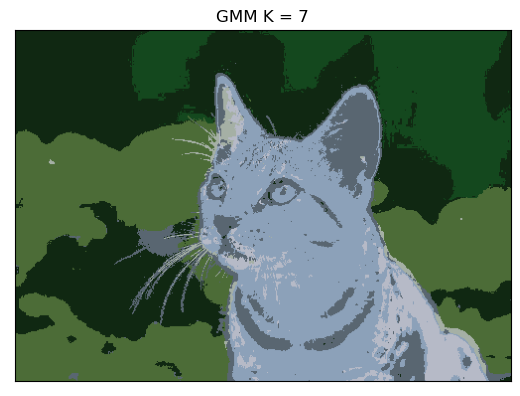

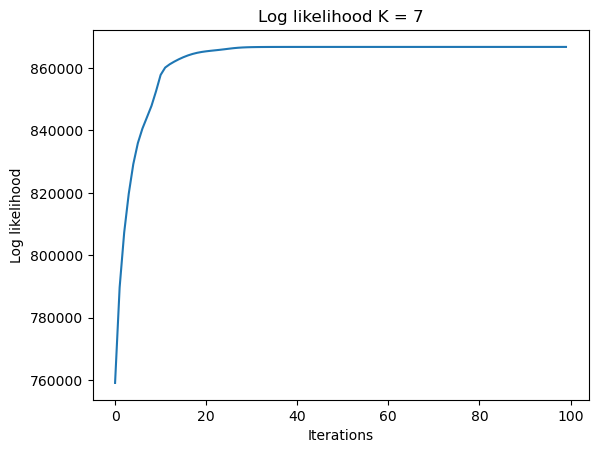



K = 20:
------------------------------
K-means:   R   |  G   |  B
------------------------------
0      :   29  |  55  |  19
------------------------------
1      :  114  | 151  | 207
------------------------------
2      :   92  | 133  |  71
------------------------------
3      :   18  |  71  |  27
------------------------------
4      :   72  |  98  |  45
------------------------------
5      :  181  | 187  | 206
------------------------------
6      :  190  | 199  | 219
------------------------------
7      :   15  |  55  |  20
------------------------------
8      :  192  | 189  | 238
------------------------------
9      :   11  |  30  |  15
------------------------------
10     :   93  |  97  | 148
------------------------------
11     :   11  |  35  |  17
------------------------------
12     :   29  |  49  |  20
------------------------------
13     :   63  |  93  |  44
------------------------------
14     :   57  |  64  | 151
------------------------------
15     :   23  |

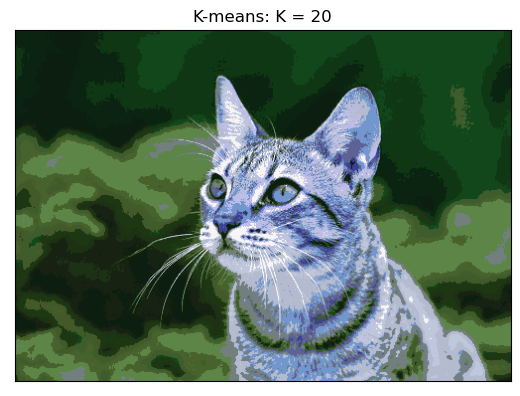



GMM K = 20:
------------------------------
           R   |  G   |  B
------------------------------
0      :   32  |  56  |  23
------------------------------
1      :  142  | 162  | 185
------------------------------
2      :  101  | 137  |  75
------------------------------
3      :   22  |  79  |  34
------------------------------
4      :   90  | 122  |  66
------------------------------
5      :  185  | 189  | 202
------------------------------
6      :  205  | 220  | 243
------------------------------
7      :   16  |  56  |  22
------------------------------
8      :  165  | 169  | 211
------------------------------
9      :   16  |  30  |  16
------------------------------
10     :   82  | 105  | 124
------------------------------
11     :   13  |  39  |  17
------------------------------
12     :   29  |  51  |  30
------------------------------
13     :   90  | 130  |  74
------------------------------
14     :   69  |  98  | 130
------------------------------
15     :   2

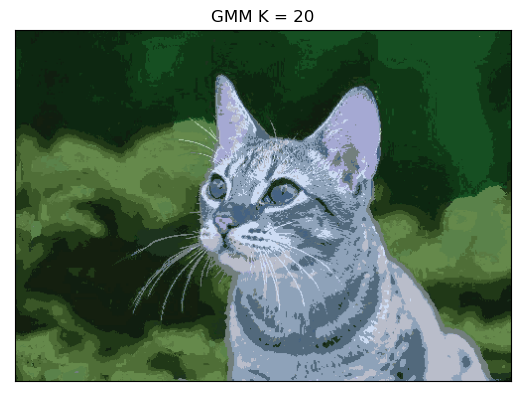

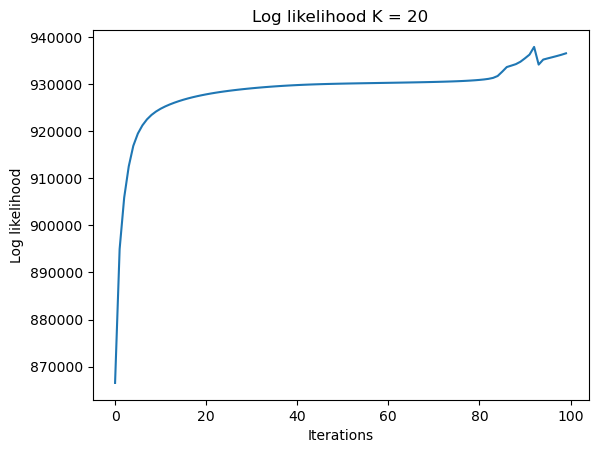

In [6]:
image = cv2.imread("./hw3.jpg")

# plt.imshow(image)
img = np.asarray(image.reshape(-1,3),dtype = 'float')/255
#print(img.shape)
K = [2,3,7,20]

def distance(r,g,b,kr,kg,kb):
    return ((r-kr)**2+(g-kg)**2+(b-kb)**2)**0.5

def initial(mu,rnk):
    tmp = np.zeros(len(rnk[0]),)
    for i in range(len(rnk)):
        for j in range(len(rnk[0])):
            tmp[j] += rnk[i,j]
    return (mu/255),tmp/len(rnk)

def kmeans(img,K,iteration,flag,control):
    r = img[:,0]
    g = img[:,1]
    b = img[:,2]
    mu = img[np.random.choice(len(img), K, replace=False)] 
    rnk = np.zeros((177000,K))
    for i in range(iteration):
        rnk_initial = rnk
        kr = mu[:,0]
        kg = mu[:,1]
        kb = mu[:,2]
        for k in range(len(img)):
            tmp = []
            for j in range(K):
                tmp.append(distance(r[k], g[k], b[k], kr[j], kg[j], kb[j]))
            rnk[k,np.argmin(tmp)] = 1
        if (rnk == rnk_initial).all():
            break
        else:
            tmp1,tmp2 = initial(mu,rnk)
            mu = np.sum(rnk.reshape(177000,K,1)*img.reshape(177000,1,3),axis=0)/(tmp2*len(rnk)).reshape(K,1)  
    mu = mu*255
    mu = mu.astype(int)
    if flag == True:
        print("K = %d:"%K)
        print('-'*30)
        print("K-means:   R   |  G   |  B"  )
        print('-'*30)
        for k in range(K):
            print("%-7d:  %3d  | %3d  | %3d" % (k, mu[k,0], mu[k,1], mu[k,2]))
            print('-'*30)
    if control == True:
        picture = mu[np.where(rnk == True)[1]]
        plt.title("K-means: K = %d"%K)
        plt.imshow(picture.reshape(354,500,3).astype(int))
        plt.xticks(())
        plt.yticks(())
        plt.show()
    return mu,rnk

# for i in range(4):
#     mu,rnk = kmeans(img,K[i],200,True,False)
#     print('\n')
    
def EM_algorithm(img,mu,rnk,K,iteration,flag,control):
    count = 0
    loglikelihood = []
    mu_initial,pi = initial(mu,rnk)
    cov = np.array([np.cov(img[np.where(rnk[:,i] == True)[0]].T) for i in range(len(rnk[0]))])
    gaussian = np.array([multivariate_normal.pdf(img,mean=mu_initial[i],cov=cov[i],allow_singular = True)*pi[i] for i in range(len(rnk[0]))])
#     print((gaussian/np.sum(gaussian,axis=0)).T.shape)
    while count < iteration:
        resp = (gaussian/np.sum(gaussian,axis=0)).T
        tmp,N_k = initial(mu,resp)
        mu_new = np.sum(img[:, None]*resp[:, :, None], axis=0)/(N_k*len(resp)).reshape(K,1)
        pi = (N_k*len(resp))/len(img)
        for j in range(K):
            cov[j] = np.dot((resp[:,j,None]*(img-mu_new[j])).T,(img-mu_new[j]))/(N_k*len(resp))[j]
            gaussian[j] = multivariate_normal.pdf(img,mu_new[j],cov[j],allow_singular = True)*pi[j]
        loglikelihood.append(np.sum(np.log(np.sum(gaussian,axis=0))))
        count += 1
    mu_new = (mu_new*255).astype(int)
    if flag == True:
        print("\n")
        print("GMM K = %d:"%K)
        print('-'*30)
        print("           R   |  G   |  B"  )
        print('-'*30)
        for k in range(K):
            print("%-7d:  %3d  | %3d  | %3d" % (k, mu_new[k,0], mu_new[k,1], mu_new[k,2]))
            print('-'*30)    
    if control == True:
        picture = mu_new[np.argmax(gaussian, axis=0)]
        plt.title("GMM K = %d"%K)
        plt.imshow(picture.reshape(354,500,3).astype(int))
        plt.xticks(())
        plt.yticks(())
        plt.show()
    plt.title("Log likelihood K = %d"%K)
    plt.plot(loglikelihood)
    plt.xlabel("Iterations")
    plt.ylabel("Log likelihood")
    plt.show()
    return

# for i in range(4):
#     mu,rnk = kmeans(img,K[i],200,False,False)
#     EM_algorithm(img,mu,rnk,K[i],100,False,False)
    
for i in range(4):
    mu,rnk = kmeans(img,K[i],200,True,True)
    EM_algorithm(img,mu,rnk,K[i],100,True,True)
    print('\n')

## 4. Make some discussion about what is crucial factor to affect the output image between K-means and Gaussian mixture model (GMM), and explain the reason.

由所得到的結果可以看出K值式影響輸出圖片的關鍵因素，圖像的清晰程度和K值的大小成正比。另外去比較K-means和GMM的差別可以發現K-means相對於GMM來說對比度更高，且圖像也比較圓滑，原因是K-means會考慮各顏色間的距離並將相近的顏色拉到同一區，而不像GMM是以機率的方向在計算。